In [1]:
# Import libraries
import json
import pandas as pd
import gzip
import math
from datetime import datetime
# To count frequency in lists
import collections

# Graphing
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Doc2vec
from gensim.models import doc2vec
from collections import namedtuple
from datetime import datetime
import re
import string
from sklearn import utils
from sklearn.model_selection import train_test_split
#import cPickle as pickle

# Hide warnings
import warnings
warnings.filterwarnings('ignore')
# ==================================================================================================

Purpose: find similar 100 products for each Amazon product

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/Users/yujinglai/Dropbox/Eugenie/data/new_amazon_cell_phone_accessories/meta_Cell_Phones_and_Accessories.json.gz')

# Drop irrelevant columns
df.drop(['image', 'feature', 'also_buy', 'also_view', 'similar_item', 'date', 'details', 'tech1', 'tech2', 'fit'], axis=1, inplace=True)

# Drop records with nan in category
df = df.dropna(subset=['category'])

In [3]:
df.shape

(534651, 8)

In [5]:
# Read the vectors
vectors = pd.read_csv('julian_vectors.csv', index_col=0, low_memory=False)

In [5]:
vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
8288878881,-0.001301,0.043438,-0.021425,0.022332,-0.018625,-0.019440,0.029104,-0.046165,-0.038056,0.018094,...,0.069609,0.034096,-0.021621,-0.021642,0.010608,-0.012038,-0.025346,-0.022125,0.044015,0.033138
9638762918,-0.000862,0.057537,-0.021205,0.055027,-0.041491,-0.035040,0.030459,-0.093126,-0.062656,0.022506,...,0.106453,0.048026,-0.027606,-0.028858,0.023098,0.010221,-0.020498,-0.055742,0.074432,0.030843
9638762632,0.014102,0.062637,-0.043580,0.059192,-0.041081,-0.044546,0.033389,-0.073598,-0.049230,-0.000484,...,0.114438,0.048697,-0.015071,-0.015552,0.019992,-0.009119,-0.023522,-0.066941,0.071139,0.032729
9678315173,-0.002911,0.052743,-0.023313,0.047230,-0.026158,-0.035186,0.023528,-0.072954,-0.057203,0.026606,...,0.103089,0.045490,-0.023857,-0.024685,0.019463,-0.002182,-0.019131,-0.049865,0.083714,0.045454
9713957334,-0.006684,0.058535,-0.013864,0.041131,-0.024932,-0.027182,0.028574,-0.063848,-0.034979,0.013868,...,0.089043,0.037169,-0.020594,-0.019888,0.008063,0.007780,-0.020687,-0.039803,0.069674,0.036748


In [6]:
def ifAmazon (x):
    if x == 'Amazon' or x == 'AmazonBasics':
        return 1
    return 0

# Add amazon label to each product
df['amazon'] = df['brand'].apply(ifAmazon)

In [7]:
# Get a list of Amazon product ids
df_amazon = df.loc[df['amazon'] == 1]
asin_amazon = df_amazon['asin']

In [8]:
# Get Amazon product vectors
vec_amazon = vectors.loc[vectors.index.isin(asin_amazon)]

In [9]:
# Take set difference
vectors = pd.concat([vectors, vec_amazon, vec_amazon]).drop_duplicates(keep=False)

In [10]:
# Generate cosine similarity matrix from vectors
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [11]:
# Get cosine similarity 
sims = cosine_similarity(vectors, vec_amazon)
sims = pd.DataFrame(sims)
sims.columns = vec_amazon.index
sims.index = vectors.index

In [12]:
# With 30,000 products in total
sim_threshold = [0.99, 0.985, 0.98, 0.975, 0.97]
sim_size = {}
for t in sim_threshold:
    size = []
    for i in range(len(sims.columns)):
        size.append(len(sims.loc[sims[sims.columns[i]] > t]))
    sim_size[t] = size
df_size = pd.DataFrame.from_dict(sim_size)
df_size.index = sims.columns
df_size

,0.99,0.985,0.98,0.975,0.97
B00511PS3C,148,1358,3823,6847,9828
B00HFEJNNO,44,203,599,1326,2533
B00MJKZHRK,15,155,474,1200,2377
B00NH12EHQ,12,84,223,500,1023
B00P0LG620,2,213,954,2283,4068
B00TEIKS1A,0,0,2,182,1655
B00Y07GJ5E,62,409,1290,2963,5394
B0115MVRO4,31,231,662,1449,2868
B019PKP87A,0,0,3,27,70


In [13]:
# Get the top 100 most similar non-Amazon products for each Amazon product
df_sims = {}
all_sims = []
n = 100
for i in range(len(sims.columns)):
    topn = list(pd.DataFrame(sims[sims.columns[i]]).sort_values(sims.columns[i]).iloc[::-1].head(n).index)
    df_sims[sims.columns[i]] = topn
    all_sims.extend(topn)
df_sims = pd.DataFrame(df_sims)
all_sims = list(set(all_sims))

In [14]:
# Get the similarity index for top 100 non-amazon products
sims_100 = sims.loc[sims.index.map(lambda x: x in all_sims)]
sims_100.shape

(798, 9)

In [15]:
thresholds = df_sims.iloc[99,:].to_dict()
keys = list(thresholds.keys())
for i in range(len(keys)):
    threshold = sims_100.loc[sims_100.index == thresholds[keys[i]]][keys[i]].item()
    thresholds[keys[i]] = threshold

thresholds

{'B00511PS3C': 0.990528139874307,
 'B00HFEJNNO': 0.9874304657758208,
 'B00MJKZHRK': 0.9862243996192405,
 'B00NH12EHQ': 0.9843610151236915,
 'B00P0LG620': 0.986488554926312,
 'B00TEIKS1A': 0.9758226023249547,
 'B00Y07GJ5E': 0.9889348785173886,
 'B0115MVRO4': 0.9876908508319052,
 'B019PKP87A': 0.967799820385278}

In [16]:
keys = list(thresholds.keys())
values = list(range(1, len(keys)+1))
sims_dict = dict(zip(keys, values))

In [17]:
sims_dict

{'B00511PS3C': 1,
 'B00HFEJNNO': 2,
 'B00MJKZHRK': 3,
 'B00NH12EHQ': 4,
 'B00P0LG620': 5,
 'B00TEIKS1A': 6,
 'B00Y07GJ5E': 7,
 'B0115MVRO4': 8,
 'B019PKP87A': 9}

In [18]:
def setZero(x):
    if x < t:
        return 0
    return x

def makeTuple(x):
    return (col, float(x))

for i in range(len(sims_100.columns)):
    col = sims_100.columns[i]
    t = thresholds[col]
    sims_100[col] = sims_100[col].apply(setZero)
    sims_100[col] = sims_100[col].apply(makeTuple)

In [19]:
for index, row in sims_100.iterrows():
    new_row = sorted(list(row), key=lambda x: x[1])[::-1]
    for i in range(len(new_row)):
        asin = new_row[i][0]
        sim_index = new_row[i][1]
        if sim_index > 0:
            #row[i] = sims_dict[asin] # 1-9 as value
            row[i] = asin # asin as value
        else:
            row[i] = 0

In [20]:
# Rename the cols
col_names = ['sim' + str(x) for x in range(1, len(sims_100.columns) + 1)]
sims_100.columns = col_names
sims_100.head()

,sim1,sim2,sim3,sim4,sim5,sim6,sim7,sim8,sim9
9713957334,B00511PS3C,0,0,0,0,0,0,0,0
B0002KRC5Y,B00HFEJNNO,0,0,0,0,0,0,0,0
B001IYSKPY,B00511PS3C,0,0,0,0,0,0,0,0
B001RMJPG0,B00511PS3C,0,0,0,0,0,0,0,0
B001XXUOQI,B00511PS3C,0,0,0,0,0,0,0,0


In [21]:
print("Number of unique non-Amazon products:", len(all_sims), "/", n*len(sims.columns))

Number of unique non-Amazon products: 798 / 900


In [22]:
# Get the number of non-Amazon products in each category
amazon_sims = list(vec_amazon.index)
amazon_sims.extend(all_sims)
df_na = df.loc[df['asin'].apply(lambda x: x in all_sims)] # Dataframe of all non-Amazon products 
df_all = df.loc[df['asin'].apply(lambda x: x in amazon_sims)] # Dataframe of all non-Amazon products 

In [40]:
# Get reviews based on the list
reviews = pd.read_csv("/Users/yujinglai/Downloads/reviews_asin.csv", index_col=0, low_memory=False)

In [41]:
def numImg(x): 
    if (type(x) is str):
        return x.count(',')
    return 0

def numVote(x):
    if (type(x) is str):
        return float(int(x.replace(',', '')))
    if (math.isnan(x)):
        return 0
    return x

# Process reviews
reviews['image'] = reviews['image'].apply(numImg) # Add image count
reviews['vote'] = reviews['vote'].apply(numVote) # Add vote count
reviews['reviewTime'] = reviews['reviewTime'].apply(lambda x: str(datetime.strptime(x, '%m %d, %Y').date()))

In [42]:
df_merged = pd.merge(reviews, df_na, on='asin')
df_all = pd.merge(reviews, df_all, on='asin')

In [43]:
reviews.shape

(2416095, 10)

In [44]:
df_merged.shape

(244157, 18)

In [45]:
df_all.shape

(245789, 18)

In [46]:
# Merge with the review data (i.e., df_all, df_na)
sims_100['asin'] = sims_100.index
df_test = pd.merge(df_all, sims_100, on='asin', how='left')

In [47]:
df_test[col_names] = df_test[col_names].fillna(0)

In [48]:
df_test.loc[df_test['asin'].apply(lambda x: x not in all_sims),'sim1'] = df_test['asin']

In [49]:
df_test[df_test['asin'].apply(lambda x: x not in all_sims)]

,asin,verified,reviewText,overall,summary,unixReviewTime,reviewerName,reviewTime,vote,image,...,amazon,sim1,sim2,sim3,sim4,sim5,sim6,sim7,sim8,sim9
1133,B00511PS3C,True,broke within 2 weeks,1.0,One Star,1489968000,vanessa Harvey,2017-03-20,0.0,0,...,1,B00511PS3C,0,0,0,0,0,0,0,0
1134,B00511PS3C,True,awesome I have two Power sights in front on my...,5.0,awesome I have two Power sights in front on my...,1487721600,Hillbilly Dreamer,2017-02-22,0.0,0,...,1,B00511PS3C,0,0,0,0,0,0,0,0
1135,B00511PS3C,True,What else is there really to know? It works,5.0,It works,1486339200,Nick,2017-02-06,0.0,0,...,1,B00511PS3C,0,0,0,0,0,0,0,0
1136,B00511PS3C,True,"Love amazon basic products, this is currently ...",4.0,Love amazon basic products,1486166400,wakari,2017-02-04,0.0,0,...,1,B00511PS3C,0,0,0,0,0,0,0,0
1137,B00511PS3C,True,Love this. It is great. It works great.,5.0,Great!!!,1485216000,Amazon Customer,2017-01-24,0.0,0,...,1,B00511PS3C,0,0,0,0,0,0,0,0
1138,B00511PS3C,True,"Yup, it charges.",5.0,Good buy,1484265600,Bert Rodriguez,2017-01-13,0.0,0,...,1,B00511PS3C,0,0,0,0,0,0,0,0
1139,B00511PS3C,True,Bought in September. It lasted until January. ...,2.0,Wouldn't recommend this one,1484265600,Britney Bennett,2017-01-13,0.0,0,...,1,B00511PS3C,0,0,0,0,0,0,0,0
1140,B00511PS3C,True,Works but it's ugly!,4.0,Ugly design,1483574400,Dan G,2017-01-05,0.0,0,...,1,B00511PS3C,0,0,0,0,0,0,0,0
1141,B00511PS3C,True,Useless without another adapter! Doesn't fit ...,2.0,Two Stars,1483574400,Vicki G.,2017-01-05,0.0,0,...,1,B00511PS3C,0,0,0,0,0,0,0,0
1142,B00511PS3C,False,Broke 2 weeks after we got it,1.0,Sad,1482883200,Nrp,2016-12-28,0.0,0,...,1,B00511PS3C,0,0,0,0,0,0,0,0


In [50]:
df_test.to_csv('similar_reviews.csv')

In [60]:
# check out the overlap: one amazon product may be so similar to another 
# generate a 9*9 table to see the overlaps between every two products
df_dups = pd.DataFrame(0, index=df_sims.columns, columns=df_sims.columns)
for i in range(9):
    for j in range(9):
        n_dups = len(set(df_sims.iloc[:,i]) & set(df_sims.iloc[:,j]))
        df_dups.iloc[i,j] = n_dups
        #print("col "+ str(i) + " and col "+ str(j) + "has "+ str(n_dups)+ " duplicates")

df_dups

,B00511PS3C,B00HFEJNNO,B00MJKZHRK,B00NH12EHQ,B00P0LG620,B00TEIKS1A,B00Y07GJ5E,B0115MVRO4,B019PKP87A
B00511PS3C,100,1,0,0,0,0,0,0,0
B00HFEJNNO,1,100,1,21,0,0,0,0,0
B00MJKZHRK,0,1,100,0,10,0,0,0,0
B00NH12EHQ,0,21,0,100,0,0,7,6,0
B00P0LG620,0,0,10,0,100,0,0,0,0
B00TEIKS1A,0,0,0,0,0,100,1,0,16
B00Y07GJ5E,0,0,0,7,0,1,100,43,0
B0115MVRO4,0,0,0,6,0,0,43,100,0
B019PKP87A,0,0,0,0,0,16,0,0,100


(array([294., 145.,  92.,  57.,  33.,  27.,  19.,  22.,   7.,  12.,   5.,
          5.,   8.,   3.,   5.,   5.,   3.,   1.,   1.,   1.,   1.,   0.,
          1.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  11,  111,  211,  311,  411,  511,  611,  711,  811,  911, 1011,
        1111, 1211, 1311, 1411, 1511, 1611, 1711, 1811, 1911, 2011, 2111,
        2211, 2311, 2411, 2511, 2611, 2711, 2811, 2911, 3011, 3111, 3211,
        3311, 3411, 3511, 3611, 3711, 3811, 3911, 4011, 4111, 4211, 4311,
        4411, 4511, 4611, 4711, 4811, 4911, 5011, 5111, 5211, 5311]),
 <a list of 53 Patch objects>)

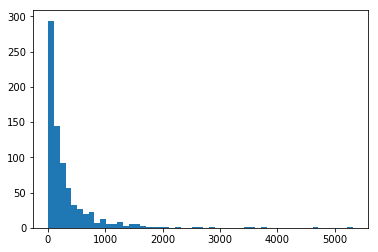

In [50]:
# hist on number of reviews per product
data = list(df_merged.groupby('asin').size())
binwidth = 100
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))

In [51]:
# amazon and non-amazon product reviews with a binary indicator
# amazon_match id 1-9, add as many as needed
df_merged.head()

,asin,verified,reviewText,overall,summary,unixReviewTime,reviewerName,reviewTime,vote,image,category,description,title,brand,rank,main_cat,price,amazon
0,9713957334,True,I got the charger 2 weeks ago and one week lat...,1.0,This is a bad product. At least the charger is...,1489968000,oswaldo lopez,2017-03-20,2.0,0,"[Cell Phones & Accessories, Accessories, Cables]",[Slim Professional HTC One (M9) Plus Genuine M...,Rapid Charging Micro-USB 2.0 Cable for HTC One...,HTC,">#477,534 in Cell Phones & Accessories (See To...",All Electronics,$6.99,0
1,9713957334,True,Not only does it take 20 minutes to charge a s...,1.0,Trash,1489622400,Ted Curtas,2017-03-16,0.0,0,"[Cell Phones & Accessories, Accessories, Cables]",[Slim Professional HTC One (M9) Plus Genuine M...,Rapid Charging Micro-USB 2.0 Cable for HTC One...,HTC,">#477,534 in Cell Phones & Accessories (See To...",All Electronics,$6.99,0
2,9713957334,True,This charger was great while it lasted. Howeve...,1.0,Does not last,1489190400,Emily,2017-03-11,0.0,0,"[Cell Phones & Accessories, Accessories, Cables]",[Slim Professional HTC One (M9) Plus Genuine M...,Rapid Charging Micro-USB 2.0 Cable for HTC One...,HTC,">#477,534 in Cell Phones & Accessories (See To...",All Electronics,$6.99,0
3,9713957334,True,cable is too short,3.0,Three Stars,1489104000,Rodney,2017-03-10,0.0,0,"[Cell Phones & Accessories, Accessories, Cables]",[Slim Professional HTC One (M9) Plus Genuine M...,Rapid Charging Micro-USB 2.0 Cable for HTC One...,HTC,">#477,534 in Cell Phones & Accessories (See To...",All Electronics,$6.99,0
4,9713957334,True,Metal piece came out. I pushed it back in but...,1.0,Don't trust,1486944000,Alicia,2017-02-13,0.0,0,"[Cell Phones & Accessories, Accessories, Cables]",[Slim Professional HTC One (M9) Plus Genuine M...,Rapid Charging Micro-USB 2.0 Cable for HTC One...,HTC,">#477,534 in Cell Phones & Accessories (See To...",All Electronics,$6.99,0
